<h1> Setup </h1>

In [1]:
from __future__ import division
import scipy                    #
from pylab import *             # includes numpy
import matplotlib.pyplot as plt # plotting libraries from matlab
import sys
sys.path.insert(2, '//global/project/projectdirs/lux/data')
import aLib

In [2]:
%pylab inline  
#always do this for plotting... don't ask me why... Googled the fix for LINUX. Run this twice

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures displayed in this notebook

<h1 style="color:red;"> Let's make a Tritium Beta Specturm ! :) </h1> <p> remember, Z'=Z+1 = 2 for Tritium Decay</p><h3> http://www.hindawi.com/journals/ahep/2013/293986/ <br/>http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.54.1891
<br/> Note on DocBD: http://teacher.pas.rochester.edu:8080/wiki/pub/Lux/LuxDB00000402/TritiumBetaShape.pdf</h3>

<h3> Defining Constants </h3>

In [4]:
c=1;    # speed of light
C=1e-6; #constant infront of Fermi funciton. Arbitrary. Read Katrin paper if you care about super-allowed and allowed transitions... and nuclear matrix elements that don't matter
me = 511/c**2; # rest mass of our good friend the electron, in keV
Q=18.6 # endpoint of the tritium Beta decay keV. Maximum kinetic energy the electron.
mv=0   # neutrino mass=0. There may exist a 17 keV neutrino, maybe 7 keV!! Will we ever know??? Is it The Dark Matter?? Mystery...
step_T=0.1 #step energy by 0.1 keV
T=arange(0.01, 18.6,step_T) #sweep from 0.01 to the Q value in increments of step_T.
Z=1+1; #Tritium, after the beta decay Z'=1+1;
halflife = 12.32; # half life of the tritium beta decay in years
tau = 365*halflife/0.69; # Decay constant converted to days
n = 1e6; # Assume 1e6 atoms are decaying.


<h3> Simplifications </h3>

In [5]:
# Fermi Function. Coulomb correction for the charge of the nucleas
G=(T+me*c**2)/(me*c**2); #Gamma, Total energy(E+M^2) over M^2
B=sqrt((G**2-1)/G**2); # v/c of electron. Ratio of velocity to speed of light in vacuum.
x=(2*pi*Z/137)/B; # note: fine structure constant = 137. 
F = x*(1/(1-exp(-x)))*(1.002037-0.001427*(B)); # from http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.54.1891. Measured to 1/1000
F_Kat=x*(1/(1-exp(-x))); # Katrin paper... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)

<h3> more blah blah blah equations, they never seem to end! </h3>

In [6]:
KE=T; #(G-1).*me*c^2; % The kinetic energy, is equal to T
E=KE+me*c**2; # the total energy. KE + rest mass
P=sqrt(E**2-me**2*c**4)/c; # momentum of the electron

<h3> Let's calculate the number density of final states in two ways... makes no difference for LUX </h3>

In [7]:
N=C*P*E*(Q+me-E)*sqrt((Q+me-E)**2-mv**2)*F # in terms of total energy. E=m0+KE. Or where Q means Q+m0
N_Kat=C*F_Kat*(KE+me)*sqrt((KE+me)**2-me**2)*(Q-KE)**2 # eqution 18 of Katrin paper. Set nutrino mass to zero... http://www.hindawi.com/journals/ahep/2013/293986/ (really the same thing)

<h3> Normalize the count to number of atoms </h3>

In [8]:
s = sum(N[~isnan(N)])*step_T # Total Counts
s_Kat = sum(N_Kat[~isnan(N_Kat)])*step_T # Total Counts (for the Katrin paper case)

N = N * (1/s * n/tau) # Decays/keV/day/1e6 atoms
N_Kat = N_Kat * (1/s * n/tau) # Decays/keV/day/1e6 atoms

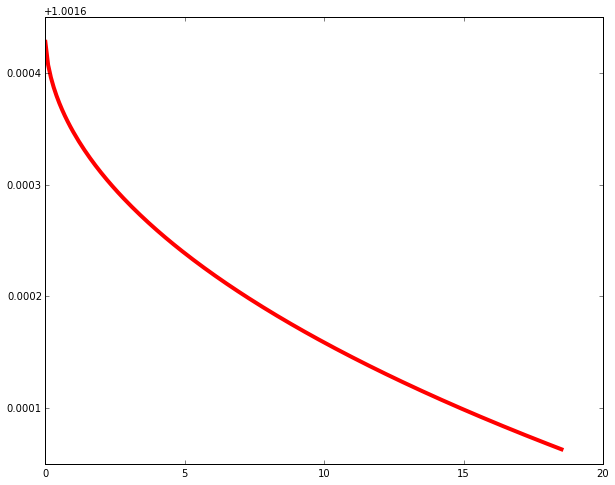

In [9]:
plt.plot(T,N/N_Kat,'r',linewidth=4)

<h3> create variable of kinetic energy T and N (count/dE) </h3>

In [9]:
tritium_beta_spectrum=array([T,N])

<h3 style="color:magenta;"> Make Plots!!! Woooo Plots </h3>

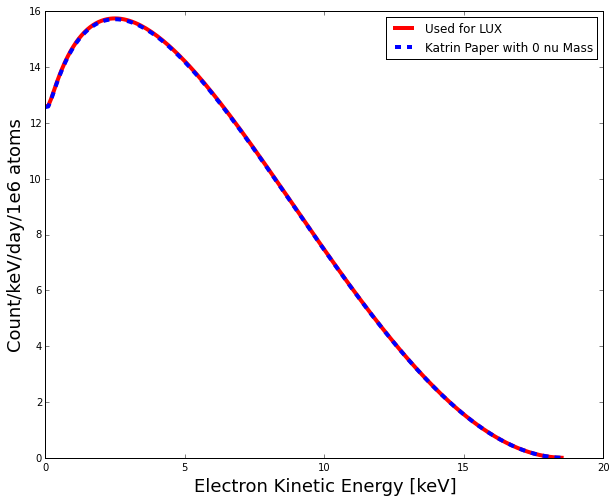

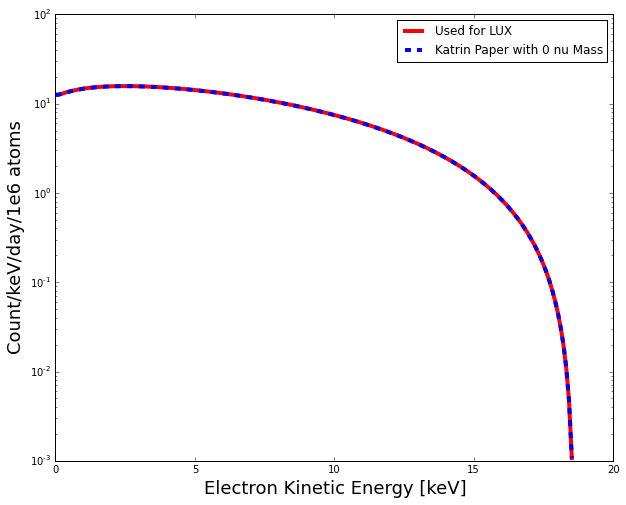

In [10]:
figure(0)
plt.plot(T,N,'r',linewidth=4)
plt.plot(T,N_Kat,'--b',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)
plt.legend(('Used for LUX','Katrin Paper with 0 nu Mass'))

figure(1)
plt.plot(T,N,'r',linewidth=4)
plt.plot(T,N_Kat,'--b',linewidth=4)
plt.xlabel('Electron Kinetic Energy [keV] ',fontsize=18)
plt.ylabel('Count/keV/day/1e6 atoms',fontsize=18)
plt.yscale('log')
plt.legend(('Used for LUX','Katrin Paper with 0 nu Mass'))

<h1 style="color:red;"> Adding Detector Resolution.</h1>
<h3> We define energy as some linear combination of number of photons and electrons that we collect, so sigma E is a function of sigma N_photons and sigma N_electrons </h3>

<h3>
E/W= N_gamma + N_electron <br/>
E/W= S1/g1 + S2/g2
</h3>

<h3 style="color:magenta;">Generate Tritium spectrum with detector resolution and recombination variance</h3>

<h3> First over estimate the smearing. Include instrumental fluctuations and more S1 smearing from PMT single PE width. Use NEST v98 to start, good first guess </h3>

In [13]:
#Load NEST LY,QY [2 3] -> Doke-Tritium LY,QY [4 5] -> and Tritium_Beta LY,QY [6 7]
tritium_beta=np.loadtxt('//global/project/projectdirs/lux/data/Tritium_Spec_LYQY.txt')
tritium_beta[:,0]=T
tritium_beta[:,1]=N

#Load the Dec 2013 tritium data.VUV corrected, spike count for S1. XYZ corrected rq with 83Kr. Cut from 35-300us. <20cm radius.
tritium_data=np.loadtxt('//global/project/projectdirs/lux/data/DEC_2013_T_Data.txt')

<h3> Defind the combined energy variable from the tritium data </h3>

In [19]:
g1_WS=0.118*0.97 #3% drop after Oct 2013 from Kr calibration
SE_WS=24.66
Eeff_WS=(12.1/SE_WS)
SE_data=23.77 #measured in Dec2013 during the tritium calibration
SE_WS=24.66
g2_data=(Eeff_WS*SE_WS)*0.97 #3% drop after Oct 2013 fro Kr calibration


g1_Beta=0.115
g2_Beta=12.1
Eeff_Beta=g2_Beta/SE_data

In [20]:
g1_Doke_old=0.116*.97
g2_Doke_old=(0.473*24.66)*.97

In [21]:
E_data=1/73*(tritium_data[:,0]/g1_data + tritium_data[:,1]/g2_data)
E_Doke=1/73*(tritium_data[:,0]/g1_Doke_old + tritium_data[:,1]/g2_Doke_old)
E_Beta=1/73*(tritium_data[:,0]/g1_Beta + tritium_data[:,1]/g2_Beta)

In [22]:
# Setup constants...
ex_to_ion_alpha=0.20; #exciton to ion ratio ... alpha

sigma_PE=0.50; # resolution of 1 photon. We are using spike count, so this should be 0
sigma_SE=5.6; #5.6 PE both, 3.8 PE bottom-only.

inst_s1=6; #measured from Doke 6 ... seems to turn off below ~200 keV ?
inst_s2=8; #measured from Doke 8  ... seems turn off below ~200 keV ?
#using 0.85 as average extraction factor for a 1000 us electron lifetime
#and 320 us drift length.

g1=g1_WS #From Doke plot
Eeff=Eeff_WS #From Doke plot #### Please NOTE: using 0.48 makes NO FREAKING DIFFERENCE!!! try for yourself :) 
SE_size = 23.77 # For December tritium data.... use 24.66 in Aug 2013, same as W.S.

#######################################################################################################
coeff_ng_sig_stat=sqrt((1-g1+sigma_PE**2)/g1);
coeff_ne_sig_stat=sqrt(((1-Eeff)*Eeff*SE_size**2+Eeff*sigma_SE**2)*0.85/(Eeff*SE_size)**2+0.155);

trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,2] # 2 for NESTv98 LY, 5 is with first fit to tritium.
    mean_e_T=tritium_beta[jj,3] # 3 for NESTv98 QY, 6 is with first fit to tritium.

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1): #% one energy bin, test for recombination and stat
        
        recomb_fluc = np.random.normal(0,sqrt(Recomb_V_T),1) #mu, sigma , 1
        Fano_fluc= 0; #normrnd(0,sqrt(Fano_V));
        #Add functional form of S1 and S2 smearing%%%%%%%%%%%%%%%%
        sigma_stat_gamma_R= sqrt(abs((coeff_ng_sig_stat*sqrt(abs(mean_gamma_T+recomb_fluc+r_T*Fano_fluc)))**2+(inst_s1/100*(mean_gamma_T+recomb_fluc+r_T*Fano_fluc) )**2 ));
        sigma_stat_e_R= sqrt(abs((coeff_ne_sig_stat*sqrt(abs(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc)))**2 + (inst_s2/100*(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc) )**2 )); 

        gamma_T[kk]=np.random.normal(mean_gamma_T+recomb_fluc+r_T*Fano_fluc,sigma_stat_gamma_R,1) #recomb + photons and - electrons
        e_T[kk]= np.random.normal(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc,sigma_stat_e_R,1) #%recomb - photons and + electrons
        kk=kk+1;

#photon spectrum: gamma_T
#electron spectrum: e_T
# Energy...-> now smeared with detector resultion.
E_com_Tsim_NEST_PE=1/73*(gamma_T+e_T); 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [24]:
# Setup constants...
ex_to_ion_alpha=0.20; #exciton to ion ratio ... alpha

sigma_PE=0.0; # resolution of 1 photon. We are using spike count, so this should be 0
sigma_SE=5.6; #5.6 PE both, 3.8 PE bottom-only.

inst_s1=0; #measured from Doke 6 ... seems to turn off below ~200 keV ?
inst_s2=0; #measured from Doke 8  ... seems turn off below ~200 keV ?
#using 0.85 as average extraction factor for a 1000 us electron lifetime
#and 320 us drift length.

g1=g1_data #From Doke plot
Eeff=Eeff_data #From Doke plot
SE_size = 23.77 # For December tritium data.... use 24.66 in Aug 2013, same as W.S.

#######################################################################################################
coeff_ng_sig_stat=sqrt((1-g1+sigma_PE**2)/g1);
coeff_ne_sig_stat=sqrt(((1-Eeff)*Eeff*SE_size**2+Eeff*sigma_SE**2)*0.85/(Eeff*SE_size)**2+0.155);

trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,2] # 2 for NESTv98 LY, 5 is with first fit to tritium.
    mean_e_T=tritium_beta[jj,3] # 3 for NESTv98 QY, 6 is with first fit to tritium.

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1): #% one energy bin, test for recombination and stat
        
        recomb_fluc = np.random.normal(0,sqrt(Recomb_V_T),1) #mu, sigma , 1
        Fano_fluc= 0; #normrnd(0,sqrt(Fano_V));
        #Add functional form of S1 and S2 smearing%%%%%%%%%%%%%%%%
        sigma_stat_gamma_R= sqrt(abs((coeff_ng_sig_stat*sqrt(abs(mean_gamma_T+recomb_fluc+r_T*Fano_fluc)))**2+(inst_s1/100*(mean_gamma_T+recomb_fluc+r_T*Fano_fluc) )**2 ));
        sigma_stat_e_R= sqrt(abs((coeff_ne_sig_stat*sqrt(abs(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc)))**2 + (inst_s2/100*(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc) )**2 )); 

        gamma_T[kk]=np.random.normal(mean_gamma_T+recomb_fluc+r_T*Fano_fluc,sigma_stat_gamma_R,1) #recomb + photons and - electrons
        e_T[kk]= np.random.normal(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc,sigma_stat_e_R,1) #%recomb - photons and + electrons
        kk=kk+1;

#photon spectrum: gamma_T
#electron spectrum: e_T
# Energy...-> now smeared with detector resultion.
E_com_Tsim_NEST_NOPE=1/73*(gamma_T+e_T); 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [25]:
# Setup constants...
ex_to_ion_alpha=0.20; #exciton to ion ratio ... alpha

sigma_PE=0.0; # resolution of 1 photon. We are using spike count, so this should be 0
sigma_SE=5.6; #5.6 PE both, 3.8 PE bottom-only.

inst_s1=0; #measured from Doke 6 ... seems to turn off below ~200 keV ?
inst_s2=0; #measured from Doke 8  ... seems turn off below ~200 keV ?
#using 0.85 as average extraction factor for a 1000 us electron lifetime
#and 320 us drift length.

g1=g1_data #From Doke plot
Eeff=Eeff_data #From Doke plot
SE_size = 23.77 # For December tritium data.... use 24.66 in Aug 2013, same as W.S.

#######################################################################################################
coeff_ng_sig_stat=sqrt((1-g1+sigma_PE**2)/g1);
coeff_ne_sig_stat=sqrt(((1-Eeff)*Eeff*SE_size**2+Eeff*sigma_SE**2)*0.85/(Eeff*SE_size)**2+0.155);

trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,4] # 2 for NESTv98 LY, 4 is with first fit to tritium.
    mean_e_T=tritium_beta[jj,5] # 3 for NESTv98 QY, 5 is with first fit to tritium.

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1): #% one energy bin, test for recombination and stat
        
        recomb_fluc = np.random.normal(0,sqrt(Recomb_V_T),1) #mu, sigma , 1
        Fano_fluc= 0; #normrnd(0,sqrt(Fano_V));
        #Add functional form of S1 and S2 smearing%%%%%%%%%%%%%%%%
        sigma_stat_gamma_R= sqrt(abs((coeff_ng_sig_stat*sqrt(abs(mean_gamma_T+recomb_fluc+r_T*Fano_fluc)))**2+(inst_s1/100*(mean_gamma_T+recomb_fluc+r_T*Fano_fluc) )**2 ));
        sigma_stat_e_R= sqrt(abs((coeff_ne_sig_stat*sqrt(abs(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc)))**2 + (inst_s2/100*(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc) )**2 )); 

        gamma_T[kk]=np.random.normal(mean_gamma_T+recomb_fluc+r_T*Fano_fluc,sigma_stat_gamma_R,1) #recomb + photons and - electrons
        e_T[kk]= np.random.normal(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc,sigma_stat_e_R,1) #%recomb - photons and + electrons
        kk=kk+1;

#photon spectrum: gamma_T
#electron spectrum: e_T
# Energy...-> now smeared with detector resultion.
E_com_Tsim_Doke=1/73*(gamma_T+e_T); 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


In [26]:
# Setup constants...
ex_to_ion_alpha=0.20; #exciton to ion ratio ... alpha

sigma_PE=0.0; # resolution of 1 photon. We are using spike count, so this should be 0
sigma_SE=5.6; #5.6 PE both, 3.8 PE bottom-only.

inst_s1=0; #measured from Doke 6 ... seems to turn off below ~200 keV ?
inst_s2=0; #measured from Doke 8  ... seems turn off below ~200 keV ?
#using 0.85 as average extraction factor for a 1000 us electron lifetime
#and 320 us drift length.

g1=g1_data #From Doke plot
Eeff=Eeff_data #From Doke plot
SE_size = 23.77 # For December tritium data.... use 24.66 in Aug 2013, same as W.S.

#######################################################################################################
coeff_ng_sig_stat=sqrt((1-g1+sigma_PE**2)/g1);
coeff_ne_sig_stat=sqrt(((1-Eeff)*Eeff*SE_size**2+Eeff*sigma_SE**2)*0.85/(Eeff*SE_size)**2+0.155);

trial_m=500; # about 150k with trial_m = 100
trials=sum(ceil(tritium_beta[:,1]*trial_m)); #tritium dN/dE is fractional so multiply amplitute. 
subtrials=np.ones((tritium_beta[:,1].size,1));

gamma_T=np.ones((trials,1)); #  Tritium gamma spectrum
e_T=np.ones((trials,1));     #  Tritium electron spectrum.


kk=1; # kk will equal the total number of simulated tritium events

for jj in range(0, tritium_beta[:,0].size): #% sweep through each energy bin
    print(jj),
    subtrials[jj]=ceil(tritium_beta[jj,1]*trial_m)
    mean_gamma_T=tritium_beta[jj,6] # 2 for NESTv98 LY, 4 is with first Doke fit to tritium. 6 second beta method
    mean_e_T=tritium_beta[jj,7] # 3 for NESTv98 QY, 5 is with first Doke fit to tritium. 7 second beta method

    n_ion_T=(mean_gamma_T+mean_e_T)/(1+ex_to_ion_alpha);
    r_T=(mean_gamma_T/mean_e_T-ex_to_ion_alpha)/(mean_gamma_T/mean_e_T+1) #mean recombination fraction

    #Add functional form of recombination variance.%%%%%%%%%%%%%%%%%%% Cancels out in E space
    Recomb_V_T=(0.07*n_ion_T)**2;
    Fano_V=0; 

    for ii in range(0, subtrials[jj]-1): #% one energy bin, test for recombination and stat
        
        recomb_fluc = np.random.normal(0,sqrt(Recomb_V_T),1) #mu, sigma , 1
        Fano_fluc= 0; #normrnd(0,sqrt(Fano_V));
        #Add functional form of S1 and S2 smearing%%%%%%%%%%%%%%%%
        sigma_stat_gamma_R= sqrt(abs((coeff_ng_sig_stat*sqrt(abs(mean_gamma_T+recomb_fluc+r_T*Fano_fluc)))**2+(inst_s1/100*(mean_gamma_T+recomb_fluc+r_T*Fano_fluc) )**2 ));
        sigma_stat_e_R= sqrt(abs((coeff_ne_sig_stat*sqrt(abs(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc)))**2 + (inst_s2/100*(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc) )**2 )); 

        gamma_T[kk]=np.random.normal(mean_gamma_T+recomb_fluc+r_T*Fano_fluc,sigma_stat_gamma_R,1) #recomb + photons and - electrons
        e_T[kk]= np.random.normal(mean_e_T-recomb_fluc+(1-r_T)*Fano_fluc,sigma_stat_e_R,1) #%recomb - photons and + electrons
        kk=kk+1;

#photon spectrum: gamma_T
#electron spectrum: e_T
# Energy...-> now smeared with detector resultion.
E_com_Tsim_Beta=1/73*(gamma_T+e_T); 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185


"\nn_1, bins_1, patches = plt.hist(E_com_Tsim_NEST_NOPE, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red', histtype='step', alpha=0.9)\nplt.xlabel('Energy KeVee',fontsize=18)\nplt.ylabel('normalized count',fontsize=18)\n\nn_2, bins_2, patches = plt.hist(E_com_Tsim_Doke, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='blue', histtype='step', alpha=0.9)\nplt.xlabel('Energy KeVee',fontsize=18)\nplt.ylabel('normalized count',fontsize=18)\n\nn_3, bin_edges_3, patches = plt.hist(E_com_Tsim_Beta, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='green', histtype='step', alpha=0.9)\nplt.xlabel('Energy KeVee',fontsize=18)\nplt.ylabel('normalized count',fontsize=18)\nleft_3,right_3 = bin_edges_3[:-1],bin_edges_3[1:]\nbin_center_3=(right_3+left_3)/2\n\nscale_factor=sum(N)*0.1/(sum(n)*binwidth)\n\nplt.plot(T,N/scale_factor,'

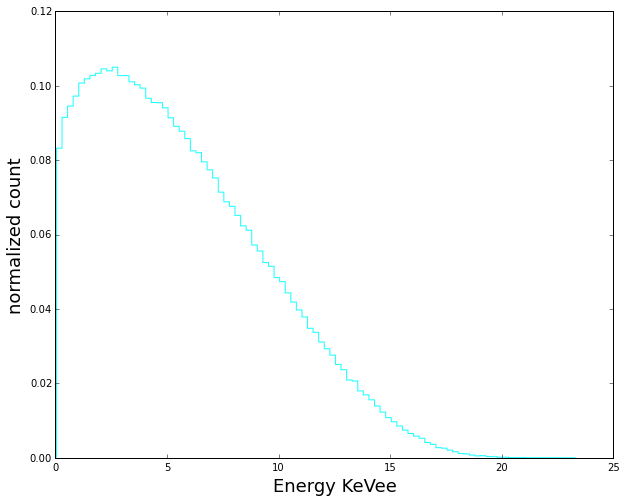

In [36]:
binwidth=0.25 # keV

n_1, bin_edges_1, patches = plt.hist(E_com_Tsim_NEST_PE, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='cyan', histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)
left_1,right_1 = bin_edges_1[:-1],bin_edges_1[1:]
bin_center_1=(right_1+left_1)/2

scale_factor=sum(N)*0.1/(sum(n_1)*binwidth)

'''
n_1, bins_1, patches = plt.hist(E_com_Tsim_NEST_NOPE, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red', histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

n_2, bins_2, patches = plt.hist(E_com_Tsim_Doke, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='blue', histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

n_3, bin_edges_3, patches = plt.hist(E_com_Tsim_Beta, bins=np.arange(0.05, max(E_com_Tsim_NEST_PE) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='green', histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)
left_3,right_3 = bin_edges_3[:-1],bin_edges_3[1:]
bin_center_3=(right_3+left_3)/2

scale_factor=sum(N)*0.1/(sum(n)*binwidth)

plt.plot(T,N/scale_factor,'m',linewidth=2)
plt.legend(('Beta spectrum, infinite resolution','With inst. flucs','NEST w/o inst. flcs','Doke LY QY','Beta LY QY'))
plt.yscale('log')
'''

<h3> The take away: Within reason, how you model detector resolution makes little impact on the smearing. The bisggest systematic is turning instrumental fluctuations on/off</h3>

<h3 style='color:red;'> The December 2013 the data </h3>

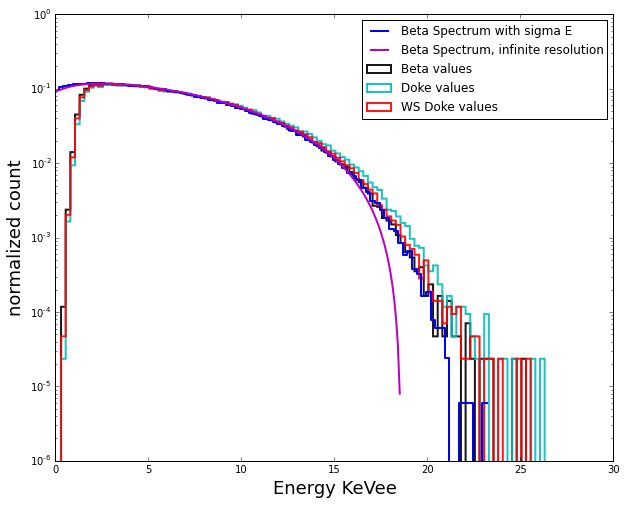

In [43]:
binwidth=0.25 # keV

n_data, bin_edges_data, patches = plt.hist(E_Beta, bins=np.arange(0.05, max(E_Beta) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='black',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

n_data_old, bin_edges_data_old, patches = plt.hist(E_Doke, bins=np.arange(0.05, max(E_Doke) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='c',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

n_data, bin_edges_data, patches = plt.hist(E_data, bins=np.arange(0.05, max(E_data) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

left,right = bin_edges_data[:-1],bin_edges_data[1:]
bin_center_data=(right+left)/2

data_scale_factor=sum(n_data[bin_center_data>3])/sum(n_1[bin_center_1>3])

plt.step(bin_center_1,n_1*data_scale_factor,'b',linewidth=2)
plt.plot(T,N/scale_factor*data_scale_factor,'m',linewidth=2)

plt.legend(('Beta Spectrum with sigma E','Beta Spectrum, infinite resolution','Beta values','Doke values','WS Doke values'))
plt.yscale('log')

In [47]:
12.1/.97


12.474226804123711

<h3> Log Scale </h3>

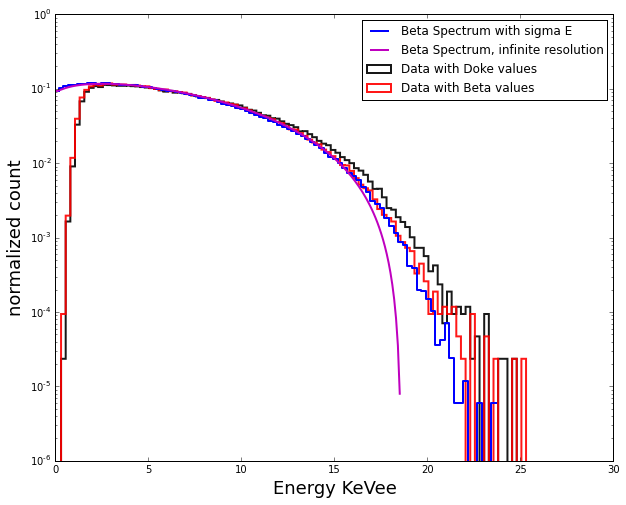

In [41]:
binwidth=0.25 # keV

n_data, bin_edges_data, patches = plt.hist(E_data, bins=np.arange(0.05, max(E_Beta) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='black',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

n_data, bin_edges_data, patches = plt.hist(E_Beta, bins=np.arange(0.05, max(E_Beta) + binwidth, binwidth), normed=1, facecolor='none',edgecolor='red',linewidth=2, histtype='step', alpha=0.9)
plt.xlabel('Energy KeVee',fontsize=18)
plt.ylabel('normalized count',fontsize=18)

left,right = bin_edges_data[:-1],bin_edges_data[1:]
bin_center_data=(right+left)/2

data_scale_factor=sum(n_data[bin_center_data>3])/sum(n_1[bin_center_1>3])

plt.step(bin_center_1,n*data_scale_factor,'b',linewidth=2)
plt.plot(T,N/scale_factor*data_scale_factor,'m',linewidth=2)

plt.legend(('Beta Spectrum with sigma E','Beta Spectrum, infinite resolution','Data with Doke values','Data with Beta values'))
plt.yscale('log')